# Path integration and navigation

**Note:** This tutorial builds on the flygym [path integration example](https://github.com/NeLy-EPFL/flygym/tree/main/flygym/examples/path_integration).

**Summary:** In this tutorial, we will use path integration (step counting) to allow the fly to estimate its position over time, and to control its movements through the world.

**Summary**: During this week's course, we learned that the fruitfly *Drosophila* melanogaster, is able to remember the location of a food source in an environement devoid of external stimuli or landmarks. To do so flies integrate their path. To perfrom path integration the fly uses an internal model that converts it's idiothetic (internal) observations to world relevant information. In [A. Behbahani et al.](https://www.sciencedirect.com/science/article/pii/S0960982221011088?via%3Dihub) fly integrate their path using very abstract integrators. 

In this week's exercise we will exploit the embodiement of Neuromechfly to collect random exploration data and explore different idiothetic cues *Drosophila* melanogaster could use to perform path integration.

In [7]:
import numpy as np
from flygym.arena import BaseArena
from flygym.examples.locomotion import CPGNetwork, PreprogrammedSteps
from flygym import Fly, YawOnlyCamera
from flygym.preprogrammed import all_leg_dofs
from flygym.simulation import SingleFlySimulation
from gymnasium import spaces
from gymnasium.core import ObsType
from scipy.spatial.transform import Rotation as R
from pathlib import Path

from utils.utils import BaseBallIntegrationArena, TurningController, SimpleHeadStabilisedFly

def absolute_to_relative_pos_heading(
    pos: np.ndarray, base_pos: np.ndarray, heading: float
) -> np.ndarray:
    rel_pos = pos - base_pos
    angle = heading
    rot_matrix = np.array(
        [[np.cos(-angle), -np.sin(-angle)], [np.sin(-angle), np.cos(-angle)]]
    )
    return rel_pos @ rot_matrix.T

def create_sim(**kwargs):
    
    fly = SimpleHeadStabilisedFly(**kwargs)

    cam_params = {
        "mode": "fixed",
        "pos": (-15, 0, 6),
        "euler": (np.pi / 2 - np.pi / 8, 0, -np.pi / 2),
        "fovy": 40,
    }

    cam = YawOnlyCamera(
        targeted_fly_names=[fly.name],
        attachment_point=fly.model.worldbody,
        camera_name="camera_behind",
        camera_parameters=cam_params,
        play_speed=0.2,
        window_size=(400, 304),
        fps=25,
    )

    arena = BaseBallIntegrationArena()

    sim = TurningController(
        fly=fly,
        cameras=[cam],
        arena=arena,
        timestep=1e-4,
        intrinsic_freqs=np.ones(6) * 25,
    )

    sim.reset(seed=0)

    return fly, cam, arena, sim

output_dir = Path("./outputs/")
output_dir.mkdir(exist_ok=True, parents=True)


## 1. Open loop control

In this exercise the we want the fly to walk around in a square. We will use a customised version of the `HybridTurningController` developed in previous exercises, but with a lot of the control simplified to allow the simulation to run faster. This controller will drive the fly through a sequence of straight lines and turns to roughly trace out a square

In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from IPython.display import display, Image, Video, clear_output

desired_square_size = 20 # the fly should run in a 20 mm square

fly, cam, arena, sim = create_sim()

display_handle = display(None, display_id=True)

obs_history = []

# if you want to, try changing these parameters to get the fly to run around a square more accurately
# the simulation timestep is 0.0001 s, so these correspond to 0.7 and 0.2 s respectively
straight_time = 0.7
turn_time = 0.2
straight_timesteps = int(round(straight_time / sim.timestep))
turn_timesteps = int(round(turn_time / sim.timestep))

# running around the arena consists of 4 straight runs and 3 turns
for i in tqdm.trange(4 * straight_timesteps + 3 * turn_timesteps):
    control = (
        (1, 1) if i % (straight_timesteps + turn_timesteps) <= straight_timesteps else (-0.8, 1.2)
    )

    obs, reward, terminated, truncated, info = sim.step(np.array(control))
    obs_history.append(obs)
    img = sim.render()

    # show the image in real time in the jupyter notebook
    if img is not None and len(img) > 0 and img[0] is not None:
        display_handle.update(
            Image(data=cv2.imencode(".jpg", img[0][:, :, ::-1])[1].tobytes())
        )

clear_output()

cam.save_video(output_dir / "baseball_open_loop.mp4", stabilization_time=0)
Video(output_dir / "baseball_open_loop.mp4")

If we plot the fly's position over time we can see that it doesn't very accurately follow the desired trajectory.

But to correct it's movements to better follow the desired path, the fly needs to know where it is at any point in time.

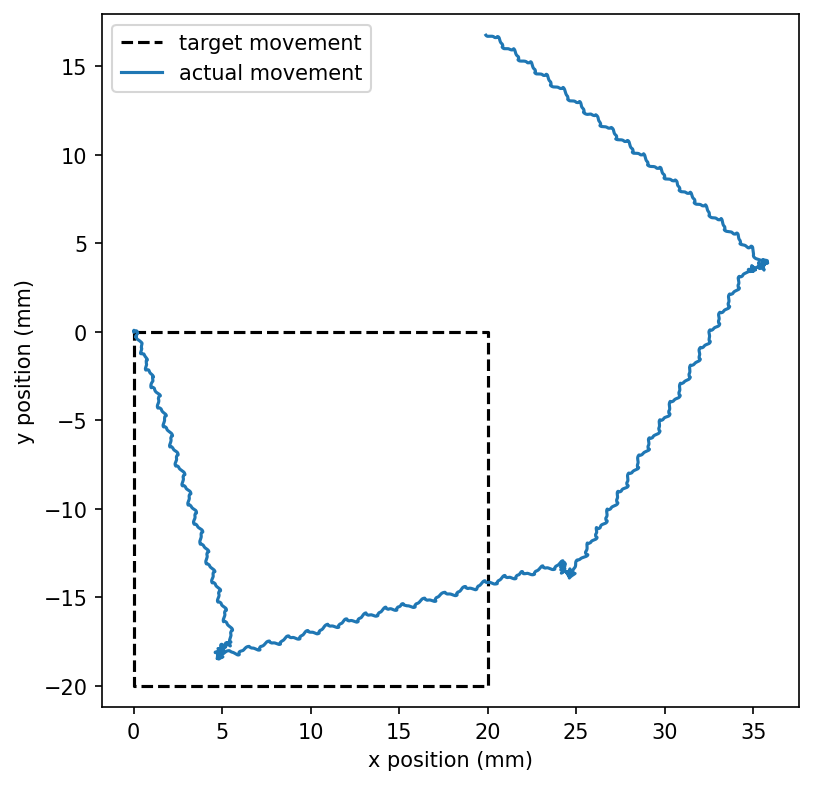

In [9]:
desired_square_size = 20
plt.figure(figsize=(6,6), dpi=150)
plt.plot(
    [0, desired_square_size, desired_square_size, 0, 0],
    [0, 0, -desired_square_size, -desired_square_size, 0],
	"k--",
	label="target movement"
)
plt.plot([observation["fly"][0][0] for observation in obs_history], [observation["fly"][0][1] for observation in obs_history], label="actual movement")
plt.legend()
plt.axis('equal')
plt.xlabel("x position (mm)")
plt.ylabel("y position (mm)")
plt.show()

# Odometry based path integration

As shown in this weeks paper: **Transforming representations of movement from body- to world-centric space** flies are able to perform odometry. [Odometry](https://en.wikipedia.org/wiki/Odometry) is defined by wikipedia as the use of data from motion sensors to estimate change in position over time. It has been long hypothesized that insects are able to perform odometry to track their orientation and position in the world.

In this week paper this has been demonstrated in an elegant way. Indeed, a particular location in a circular arena was rewarded using optogenetic. Upon extinction of the optogenetic reward, flies are starting a search behavior and circle around the arena. In the absence of any other cues (no odor, non-informative vision, no polarized light) flies are showing extended search times around the location of the now-absent optogenetic reward as indicated by the peaks in the distribution shown in panel d. This indicates that flies are capable of monitoring their orientation based on internal cues.

<img src="source/odometry_wilson2021.png" alt="https://www.nature.com/articles/s41586-021-04191-x/figures/3" width="1000" data-background-color="white">


In this notebook we propose to use proprioceptive variables in order to track the orientation and forward displacement of the fly. More specifically we will be aggregating the length of every step taken by every leg. With that we expect to be able to track the fly's heading by comparing the total step length between the right and left side of the body. Similarly we will try to track the fly's forward displacement by adding up the stride length from all the legs.


To explore these hypotheses we had NeuroMechFly performing multiple exploratory runs using the RandomExplorationController. In those experiments the fly can run forward with a descending drive of [1.0, 1.0], turn left using a descending drive of [-0.8, 1.2] and finally turn right with a descending drive of [1.2, -0.8]. The turning probability is given by a Poisson process of lambda=2. Similarly the turning duration and direction is random (more info at flygym.examples.path_integration.controller RandomExplorationController).

In the next cells we will extract the previously described quantities and explore how they might describe the heading and forward displacement of the fly.

The data can be downloaded [here](https://drive.google.com/file/d/1rZb4JBrsQ_9TwF1VeJ7ysy6EWqW6lT8m/view?usp=share_link). Please download the data, unzip it and place them in a folder called data under the current folder week6.

In [10]:
# load data
def load_trial_data(trial_path):
    sim_data = np.load(trial_path, allow_pickle=True)

    obs_hist, info_hist, actions_hist = sim_data["obs_hist"], sim_data["info_hist"], sim_data["action_hist"]

    odometry_data = {
        "end_effector_pos": [],
        "contact_force": [],
        "fly_orientation": [],
        "fly_pos": [],
        "adhesion": [],
    }

    for i in range(len(obs_hist)):
        obs = obs_hist[i]
        info = info_hist[i]        
        odometry_data["end_effector_pos"].append(obs["end_effectors"])
        odometry_data["contact_force"].append(np.linalg.norm(obs["contact_forces"], axis=1))
        odometry_data["fly_orientation"].append(obs["fly_orientation"])
        odometry_data["fly_pos"].append(obs["fly"][0])
        odometry_data["adhesion"].append(info["adhesion"])

    for key in odometry_data:
        odometry_data[key] = np.array(odometry_data[key])

    return odometry_data
    
trials_data = []
for trial_path in Path("data").rglob("*.pkl"):
    print(f"Loading trial data from {trial_path}")
    trial_data = load_trial_data(trial_path)
    trials_data.append(trial_data)

for key in trials_data[0].keys():
    print(f"{key} has shape {trials_data[0][key].shape}")

Loading trial data from data/path_integration_data/seed=1/sim_data.pkl
Loading trial data from data/path_integration_data/seed=0/sim_data.pkl
Loading trial data from data/path_integration_data/seed=2/sim_data.pkl
end_effector_pos has shape (200000, 6, 3)
contact_force has shape (200000, 6)
fly_orientation has shape (200000, 3)
fly_pos has shape (200000, 3)
adhesion has shape (200000, 6)


At this stage you should be able to make sense of every observation contained in the trial_data. 
If not please refer to previous weeks tutorials.

Let's visualize the exploration trajectories.

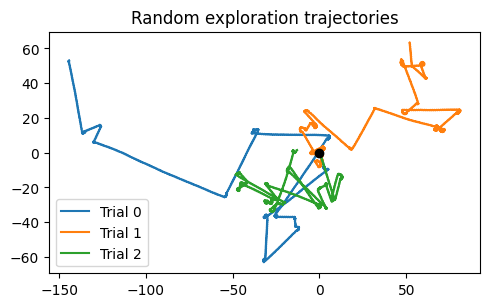

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 9), tight_layout=True)
for trial_id in range(len(trials_data)):
    fly_pos = trials_data[trial_id]["fly_pos"]
    ############################
    # TODO: Plot fly trajectories
    ax.plot(fly_pos[:, 0], fly_pos[:, 1], label=f"Trial {trial_id}")
    ############################
ax.plot([0], [0], "o", color="black")
ax.set_title(f"Random exploration trajectories")
ax.set_aspect("equal")
ax.legend()

In [12]:
def absolute_to_relative_pos(
        pos: np.ndarray, base_pos: np.ndarray, heading: np.ndarray
    ) -> np.ndarray:
    """
    This function converts an absolute position to a relative position
    with respect to a base position and heading of the fly.

    In the next cells it will be used to obtain the flycentric end effector (leg tip) positions.

    """

    rel_pos = pos - base_pos
    heading = heading / np.linalg.norm(heading)
    angle = np.arctan2(heading[1], heading[0])
    rot_matrix = np.array(
        [[np.cos(-angle), -np.sin(-angle)], [np.sin(-angle), np.cos(-angle)]]
    )
    pos_rotated = np.dot(rel_pos, rot_matrix.T)
    return pos_rotated

def get_stride_length(fly_pos, fly_orientation, end_effector_pos):

    """
    This function calculates the stride length of the fly by calculating the difference in the end effector position
    of the fly between two consecutive time steps.

    In this function the end_effector_pos is converted to a flycentric coordinate system using the absolute_to_relative_pos
    function. The stride length is calculated as the difference in the end effector position between two consecutive time steps
    in the flycentric coordinate system.

    """
    
    last_end_effector_pos = None
    stride_length = []

    for i in range(len(fly_pos)):
        rel_pos = absolute_to_relative_pos(end_effector_pos[i], fly_pos[i], fly_orientation[i])
        if last_end_effector_pos is None:
            ee_diff = np.zeros_like(rel_pos)
        else:
            ee_diff = rel_pos - last_end_effector_pos
        last_end_effector_pos = rel_pos
        
        stride_length.append(ee_diff)

    return np.array(stride_length)
            
def extact_ground_truth_variables(fly_orientation_xy, fly_pos, time_scale, dt=1e-4):

    """
    This function calculates the change in the fly's orientation and forward displacement.
    The forward displacement is calculated by projecting the change in position of the fly
    onto the fly's heading vector.
    
    """
    
    window_len = int(time_scale / dt)

    # Change in locomotion state (heading & displacement) ==========
    # Calculate change in fly orientation over proprioceptive time window (Δheading)
    heading_ts = np.arctan2(fly_orientation_xy[:, 1], fly_orientation_xy[:, 0])
    heading_diff = heading_ts[window_len:] - heading_ts[:-window_len]
    heading_diff = (heading_diff + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, π]

    # Same for displacement projected in the direction of fly's heading
    # Use projection formula: proj_v(u) = (u · v) / (v · v) * v where v is the fly's
    # heading vector and u is the change in position
    fly_disp_xy = np.diff(fly_pos, axis=0, prepend=0)
    fly_orientation_xy_norm = np.linalg.norm(fly_orientation_xy, axis=1)
    fly_orientation_xy_unit = fly_orientation_xy / fly_orientation_xy_norm[:, None]
    udotv = np.sum(fly_disp_xy * fly_orientation_xy_unit, axis=1)
    vdotv = np.sum(fly_orientation_xy_unit * fly_orientation_xy_unit, axis=1)
    forward_disp_mag = udotv / vdotv
    forward_disp_total = np.cumsum(forward_disp_mag)
    forward_disp_total_diff = (
        forward_disp_total[window_len:] - forward_disp_total[:-window_len]
    )

    return heading_diff, forward_disp_total_diff

def extract_proprioceptive_variables(stride_length, contact_force, time_scale, contact_force_thr, dt = 1e-4):
    """
    This function calculates the proprioceptive heading and distance signals.
    The proprioceptive heading signal is calculated as the difference in the stride length
    between the left and right side of the fly.

    The proprioceptive distance signal is calculated as the sum of the stride length
    of the left and right side of the fly.

    """
    window_len = int(time_scale / dt)

    # Proprioceptive signal ==========
    # Calculate total stride (Σstride) for each side
    ############################
    # TODO: Extract the stride length for each side along the x axis
    stride_left = stride_length[:, :3, 0]
    stride_right = stride_length[:, 3:, 0]
    ############################
    contact_mask = contact_force > contact_force_thr  # (L, 6)
    
    ############################
    # TODO: Calculate the stride length for the stance period
    stride_left = (stride_left * contact_mask[:, :3]).sum(axis=1)
    stride_right = (stride_right * contact_mask[:, 3:]).sum(axis=1)
    ############################

    stride_total_left = np.cumsum(stride_left, axis=0)
    stride_total_right = np.cumsum(stride_right, axis=0)

    # Calculate difference in Σstride over proprioceptive time window (ΔΣstride)
    stride_total_diff_left = (
        stride_total_left[window_len:] - stride_total_left[:-window_len]
    )
    stride_total_diff_right = (
        stride_total_right[window_len:] - stride_total_right[:-window_len]
    )

    # Calculate sum and difference in ΔΣstride over two sides
    ############################
    # TODO: Calculate the final proprioceptive
    proprioceptive_distance_pred = stride_total_diff_left + stride_total_diff_right
    proprioceptive_heading_pred = stride_total_diff_left - stride_total_diff_right
    ############################

    return proprioceptive_heading_pred, proprioceptive_distance_pred

stride_length_differences = []
stride_length_sums = []

heading_diffs = []
forward_disp_diffs = []

ts = 0.12
f_thr = 1.0
timestep = 1e-4

for trial_data in trials_data:

    stride_length = get_stride_length(trial_data["fly_pos"][:, :2], trial_data["fly_orientation"], trial_data["end_effector_pos"][:, :, :2])
    
    stride_length_difference, stride_length_sum = extract_proprioceptive_variables(
        stride_length, trial_data["contact_force"], time_scale=ts, contact_force_thr=f_thr, dt=timestep
    )
    
    heading_diff, forward_disp_diff = extact_ground_truth_variables(
        trial_data["fly_orientation"][:, :2], trial_data["fly_pos"][:, :2], time_scale=ts, dt=timestep
    )

    stride_length_differences.extend(stride_length_difference)
    stride_length_sums.extend(stride_length_sum)

    heading_diffs.extend(heading_diff)
    forward_disp_diffs.extend(forward_disp_diff)

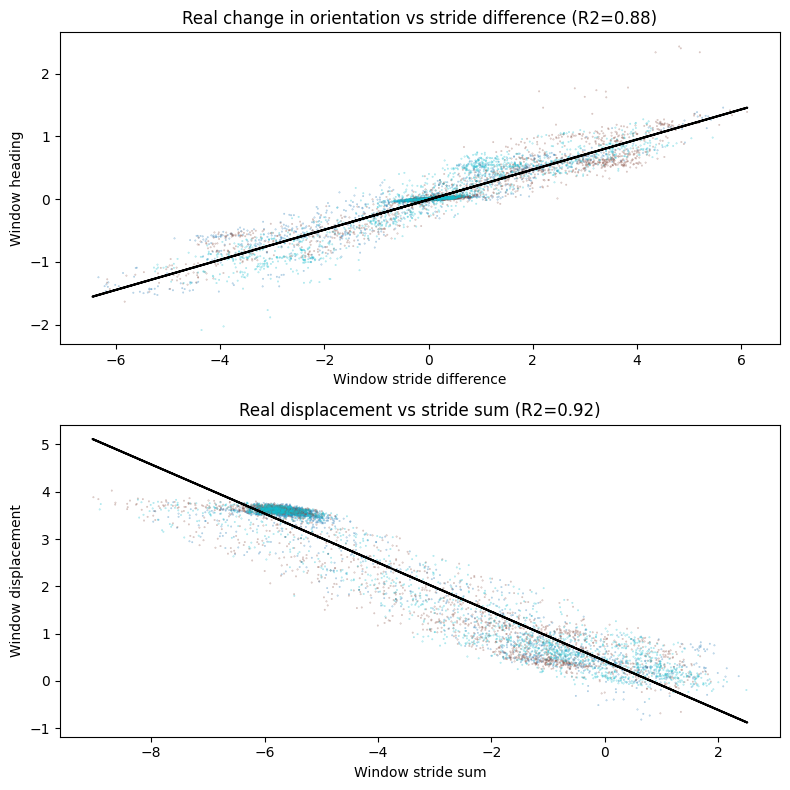

In [13]:
# fit a linear model to the proprioceptive data
def fit_1d_linear_model(x, y):
    k, b = np.polyfit(x, y, deg=1)
    model = np.poly1d([k, b])
    y_pred = model(x)
    r2 = 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2)
    return k, b, r2
k_prop_head, b_prop_head, r2_prop_head = fit_1d_linear_model(stride_length_differences, heading_diffs)
k_prop_disp, b_prop_disp, r2_prop_disp = fit_1d_linear_model(stride_length_sums, forward_disp_diffs)

prop_heading_model = np.poly1d([k_prop_head, b_prop_head])
prop_disp_model = np.poly1d([k_prop_disp, b_prop_disp])

dataset_belonging = np.repeat(np.arange(len(trials_data)), len(stride_length_sum))

fig, axs = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True)
axs[0].scatter(stride_length_differences[::100], heading_diffs[::100], c=dataset_belonging[::100], alpha=0.5, s=0.1, cmap="tab10")
axs[0].plot(stride_length_differences, prop_heading_model(stride_length_differences), color="black")
axs[0].set_xlabel("Window stride difference")
axs[0].set_ylabel("Window heading")
axs[0].set_title(f"Real change in orientation vs stride difference (R2={r2_prop_head:.2f})")

axs[1].scatter(stride_length_sums[::100], forward_disp_diffs[::100], c=dataset_belonging[::100], alpha=0.5, s=0.1, cmap="tab10")
axs[1].plot(stride_length_sums, prop_disp_model(stride_length_sums), color="black")
axs[1].set_xlabel("Window stride sum")
axs[1].set_ylabel("Window displacement")
axs[1].set_title(f"Real displacement vs stride sum (R2={r2_prop_disp:.2f})")

plt.show()

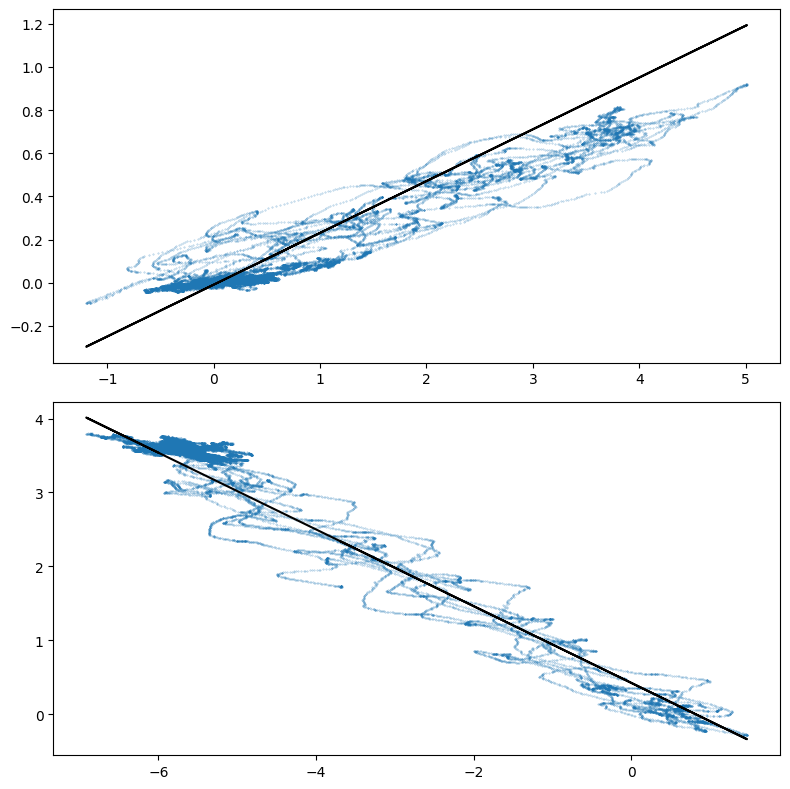

In [14]:
fly_pos = np.array([obs["fly"][0] for obs in obs_history])
fly_orientation = np.array([obs["fly_orientation"] for obs in obs_history])
end_effector_pos = np.array([obs["end_effectors"] for obs in obs_history])
contact_forces = np.array([np.linalg.norm(obs["contact_forces"], axis=1) for obs in obs_history])

stride_length = get_stride_length(fly_pos[:, :2], fly_orientation, end_effector_pos[:, :, :2])
stride_length_difference, stride_length_sum = extract_proprioceptive_variables(
    stride_length, contact_forces, time_scale=ts, contact_force_thr=f_thr, dt=timestep
)

heading_diff, forward_disp_diff = extact_ground_truth_variables(
    fly_orientation[:, :2], fly_pos[:, :2], time_scale=ts, dt=timestep
)

fig, axs = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True)
axs[0].scatter(stride_length_difference, heading_diff, alpha=0.5, s=0.1)
axs[0].plot(stride_length_difference, prop_heading_model(stride_length_difference), color="black")
axs[1].scatter(stride_length_sum, forward_disp_diff, alpha=0.5, s=0.1)
axs[1].plot(stride_length_sum, prop_disp_model(stride_length_sum), color="black")

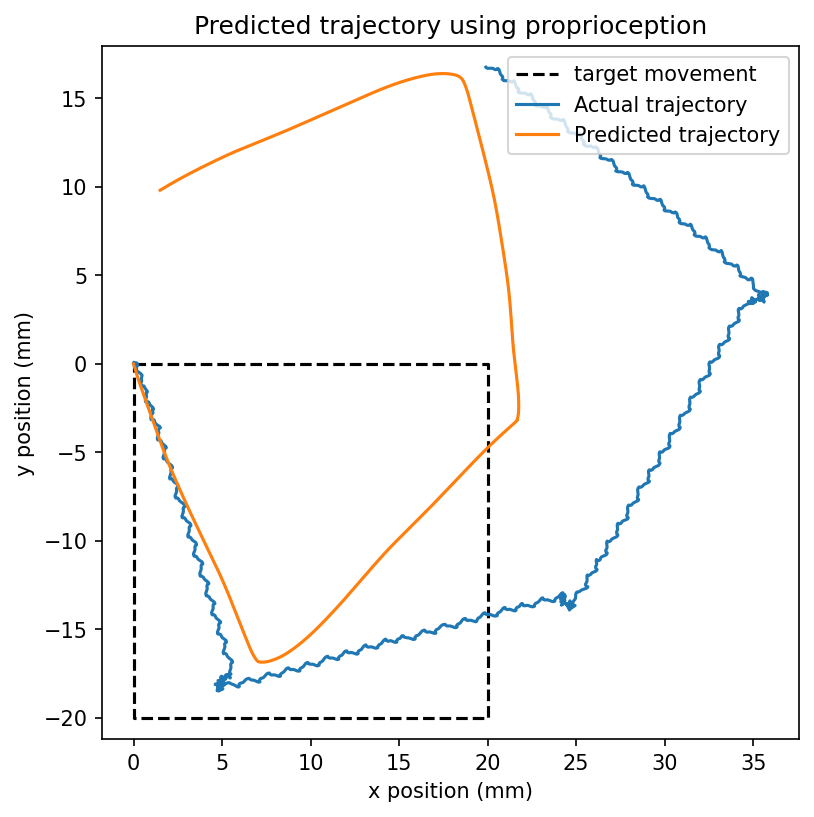

In [15]:
fly_pos = np.array([obs["fly"][0] for obs in obs_history])
fly_orientation = np.array([obs["fly_orientation"] for obs in obs_history])
end_effector_pos = np.array([obs["end_effectors"] for obs in obs_history])
contact_forces = np.array([np.linalg.norm(obs["contact_forces"], axis=1) for obs in obs_history])

stride_length = get_stride_length(fly_pos[:, :2], fly_orientation, end_effector_pos[:, :, :2])
stride_length_difference, stride_length_sum = extract_proprioceptive_variables(
    stride_length, contact_forces, time_scale=ts, contact_force_thr=f_thr, dt=timestep
)

window_len = int(ts / sim.timestep)

# Integrate heading
heading_diff_pred = prop_heading_model(stride_length_difference)
heading_pred = np.cumsum(heading_diff_pred / window_len)
# Path int. not performed when not enough data is available. Start from the real
# heading at the moment when path int. actually starts.
hx_start, hy_start = fly_orientation[window_len, :2]
real_heading_start = np.arctan2(hy_start, hx_start)
heading_pred += real_heading_start

# Integrate displacement
displacement_diff_pred = prop_disp_model(stride_length_sum)
############################
# TODO: Project the change in displacement in the direction of the current heading
displacement_diff_x_pred = np.cos(heading_pred) * displacement_diff_pred
displacement_diff_y_pred = np.sin(heading_pred) * displacement_diff_pred
############################

pos_x_pred = np.cumsum(displacement_diff_x_pred / window_len)
pos_y_pred = np.cumsum(displacement_diff_y_pred / window_len)
pos_pred = np.concatenate([pos_x_pred[:, None], pos_y_pred[:, None]], axis=1)

# Pad with NaN where prediction not available
heading_pred = np.concatenate([np.full(window_len, np.nan), heading_pred])
pos_pred = np.concatenate([np.full((window_len, 2), np.nan), pos_pred], axis=0)

desired_square_size = 20
plt.figure(figsize=(6,6), dpi=150)
plt.plot(
    [0, desired_square_size, desired_square_size, 0, 0],
    [0, 0, -desired_square_size, -desired_square_size, 0],
	"k--",
	label="target movement"
)
plt.plot([observation["fly"][0][0] for observation in obs_history], [observation["fly"][0][1] for observation in obs_history], label="Actual trajectory")
plt.plot(pos_pred[:, 0], pos_pred[:, 1], label="Predicted trajectory")
plt.title("Predicted trajectory using proprioception")
plt.legend(loc = "upper right")
plt.axis('equal')
plt.xlabel("x position (mm)")
plt.ylabel("y position (mm)")
plt.show()

From this very simple experiment it seems like the distance estimate is quite reliable while the heading estimate is less accurate at least for this first left turn. 


In a naturalistic environment the fly would have access to a few other sensory modalities. How those could be use to perform path integration and potentially improve the current framework will be explored in the rest of the exercise.

# Optic flow based path integration

Last week we have seen how the fruitfly can use vision to update it's heading during the optomotor reflex behavior. The goal of this behavior was to counteract an unexpected whole body saccade to counteract perturbations during flight or terrestrial locomotion. This week we will explore how the fruitlfy could, in a different context, use vision in order to perform path integration. 


The fruitfly has been shown in **[Neural dynamics for landmark orientation and angular path integration](https://www.nature.com/articles/nature14446)** to be able to keep track of visual cues.


Indeed, as shown in this figure, when a light blue bar is presented to a fly and its position is updated in a virtual reality setup, a population of ellipsoid body neurons are updating their firing rate so that their population code represents the location of the visual cue. 
This can be easily seen in the panel h where the azimuth of the visual cue strictly matches the location of the bump in the ellipsoid body.

<img src="source/visual_orient_seelig2015.png" alt="https://www.nature.com/articles/nature14446/figures/1" width="700" data-background-color="white">

In this exercise and for the sake of simplicity, we are using [optic flow](https://en.wikipedia.org/wiki/Optical_flow) (a quantity that is known to be computed by the fly) in order to estimate the current heading of the fly.

## Computing optic flow from the fly vision

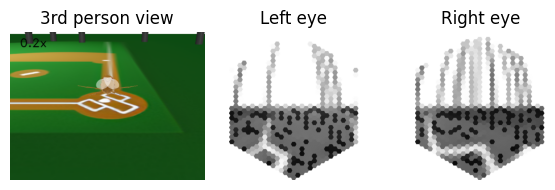

In [16]:
fly, cam, arena, sim = create_sim(enable_vision=True)

obs, info = sim.reset()
im = sim.render()[0]

vision_left = fly.retina.hex_pxls_to_human_readable(obs["vision"][0, :, :], color_8bit=True)
vision_right = fly.retina.hex_pxls_to_human_readable(obs["vision"][1, :, :], color_8bit=True)

fig, axs = plt.subplots(1, 3, figsize=(6, 2), tight_layout=True)
axs[0].imshow(im)
axs[1].imshow(vision_left.max(-1), cmap="gray", vmin=0, vmax=255)
axs[2].imshow(vision_right.max(-1), cmap="gray", vmin=0, vmax=255)

for ax, title in zip(axs, ["3rd person view", "Left eye", "Right eye"]):
    ax.set_title(title)
    ax.axis("off")

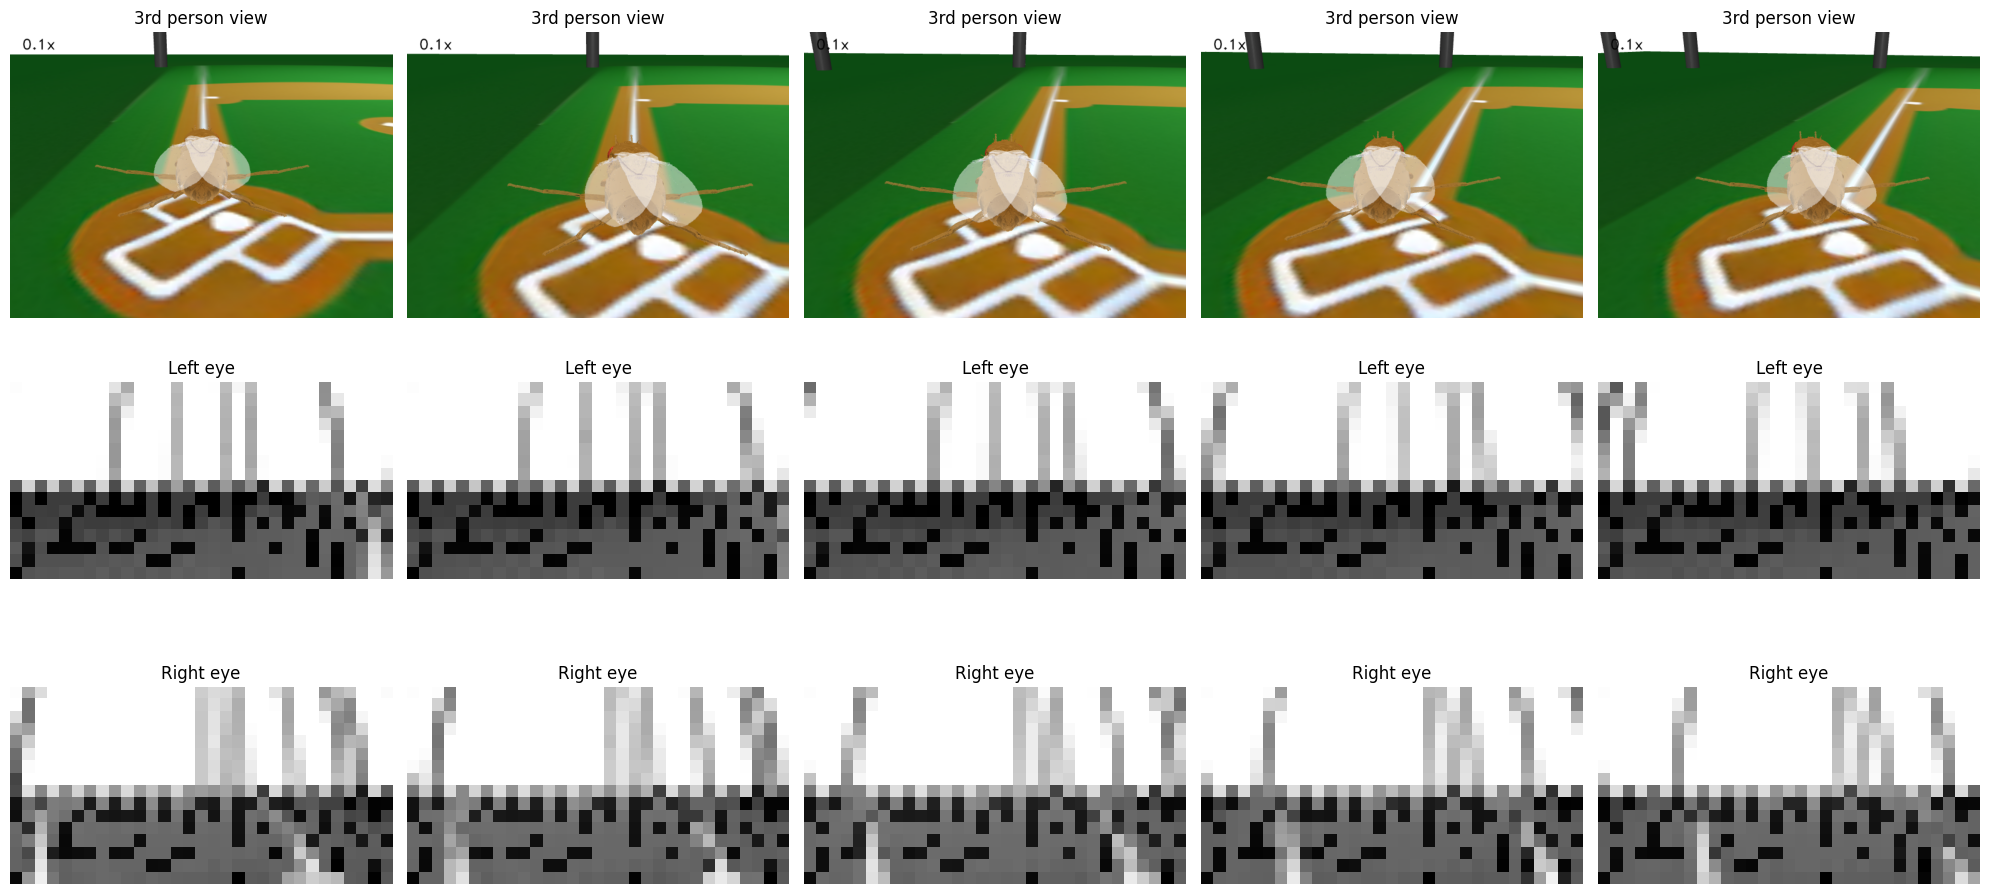

In [17]:
import sys
sys.path.append("..")
from week5.utils import crop_hex_to_rect

def render_with_roll(roll):
    arena = BaseBallIntegrationArena()

    fly = Fly(
        enable_vision=True,
        spawn_orientation=[0, 0, roll],
        render_raw_vision=True,
    )

    cam = YawOnlyCamera(
        attachment_point=fly.model.worldbody,
        camera_name="camera_back_track_game",
        targeted_fly_names=[fly.name],
        play_speed=0.1,
    )

    sim = SingleFlySimulation(
        fly=fly,
        cameras=[cam],
        arena=arena,
    )

    obs, info = sim.reset()
    sim.physics.step()

    im = sim.render()[0]

    return obs["vision"], im, info["raw_vision"]

# Redo with 5 different rolls
n_rolls = 5

fig, axs = plt.subplots(3, n_rolls, figsize=(n_rolls*4, 10), tight_layout=True)
rolls = np.linspace(0, np.pi/8, n_rolls)


vision_hist = []

for i, roll in enumerate(rolls):

    vision, im, raw_vision = render_with_roll(roll)
    vision_hist.append(vision)
   
    vision_left_rect = crop_hex_to_rect(vision[0])
    vision_right_rect = crop_hex_to_rect(vision[1])

    axs[0, i].imshow(im)
    axs[1, i].imshow(vision_left_rect, cmap="gray")
    axs[2, i].imshow(vision_right_rect, cmap="gray")
    
    for ax, title in zip(axs[:, i], ["3rd person view", "Left eye", "Right eye"]):
        ax.set_title(title)
        ax.axis("off")


From those images it is clear that the bottom half of the vision is quite noisy due to the baseball field. To perform path integration we will focus on the top 5 pixels where the distant cues and their displacement can be much more easily tracked. 

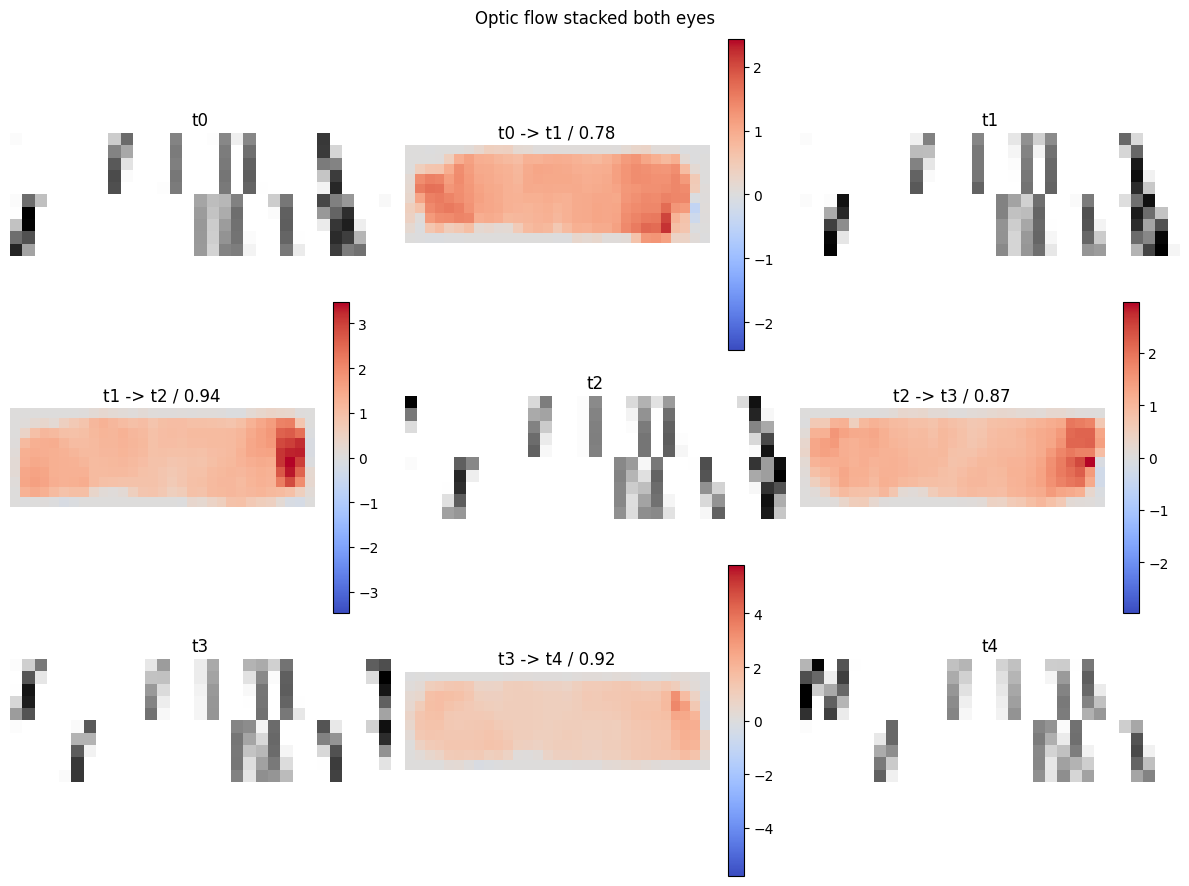

In [18]:
# perform optic flow
def compute_optic_flow(img0, img1):
    img0 = (img0 * 255).astype(np.uint8)
    img1 = (img1 * 255).astype(np.uint8)
    
    flow = cv2.calcOpticalFlowFarneback(
        img0, img1, None, 0.5, 2, 3, 2, 5, 1.1, 0
    )
    return flow

def prepare_fly_vision(two_eyes_vision, n_top_pixels=5):
    left_eye = two_eyes_vision[0]
    right_eye = two_eyes_vision[1]

    left_eye_square = crop_hex_to_rect(left_eye)
    right_eye_square = crop_hex_to_rect(right_eye)

    left_eye_top = left_eye_square[:n_top_pixels]
    right_eye_top = right_eye_square[:n_top_pixels]

    stacked_eye = np.vstack([left_eye_top, right_eye_top])

    return stacked_eye

n_plots = n_rolls + n_rolls - 1
n_cols = 3
n_rows = np.ceil(n_plots/n_cols).astype(int)
fig, axs = plt.subplots(n_cols, n_rows, figsize=(n_rows*4, n_cols*3), tight_layout=True)
flat_axs = axs.flatten()

fig.suptitle("Optic flow stacked both eyes")

ax_idx = 0
for i in range(n_rolls-1):
    pre_img = prepare_fly_vision(vision_hist[i])
    post_img = prepare_fly_vision(vision_hist[i+1])
    flow = compute_optic_flow(pre_img, post_img)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    if i == 0:
        flat_axs[ax_idx].imshow(pre_img, cmap="gray")
        flat_axs[ax_idx].set_title(f"t{i}")
        flat_axs[ax_idx].axis("off")
        ax_idx += 1
    
    vmax = np.abs(flow).max()
    vmin = -vmax
    c_img = flat_axs[ax_idx].imshow(flow[..., 0], cmap="coolwarm", vmin=vmin, vmax=vmax)
    #add colorbar
    plt.colorbar(c_img, ax=flat_axs[ax_idx])
    flat_axs[ax_idx].set_title(f"t{i} -> t{i+1} / {np.mean(flow[..., 0]):.2f}")
    flat_axs[ax_idx].axis("off")
    ax_idx += 1

    flat_axs[ax_idx].imshow(post_img, cmap="gray")
    flat_axs[ax_idx].set_title(f"t{i+1}")
    flat_axs[ax_idx].axis("off")
    ax_idx += 1


## Exploring the relationship between optic flow and change in orientation

In [19]:
n_pts_per_roll = 4
# variable density of rolls speeds 
roll_diff = np.deg2rad([15, 10, 7.5, 5, 2.5, 1, 0.5, 0.1, 0.05])
roll_diff = np.concatenate((-roll_diff, [0], roll_diff[::-1]))
n_pts = len(roll_diff)

all_predicted_rolls = []

def get_mean_x_flow(flow):
    ############################
    #TODO: calculate the mean optic flow vector in the x direction
    return np.mean(flow[..., 0])
    ############################

for roll_speed in tqdm.tqdm(roll_diff):
    rolls = np.arange(0, n_pts_per_roll) * roll_speed

    predicted_rolls = []
    prev_vis = None
    curr_vis = None

    for i, roll in enumerate(rolls):
        vision, im, raw_vision = render_with_roll(roll)
        curr_vis = prepare_fly_vision(vision)

        if prev_vis is not None:

            flow = compute_optic_flow(prev_vis, curr_vis)
            mean_x_flow = get_mean_x_flow(flow)
            predicted_rolls.append(mean_x_flow)
            
        prev_vis = curr_vis

    all_predicted_rolls.append(predicted_rolls)

all_predicted_rolls = np.array(all_predicted_rolls)    

100%|██████████| 19/19 [01:12<00:00,  3.82s/it]


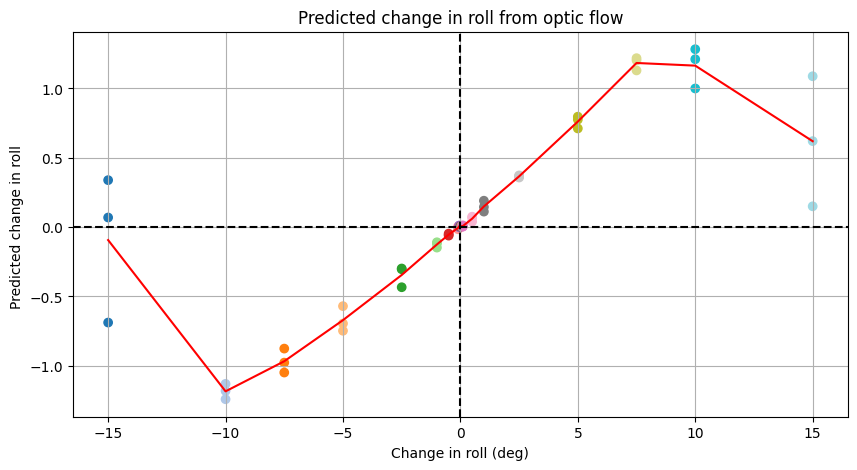

In [20]:
deg_roll_diffs = np.rad2deg(roll_diff)
plt.figure(figsize=(10, 5))

plt.scatter(deg_roll_diffs.repeat(n_pts_per_roll-1), all_predicted_rolls.flatten(), c=np.arange(n_pts).repeat(n_pts_per_roll-1), cmap="tab20")
plt.plot(deg_roll_diffs, np.mean(all_predicted_rolls, axis=1), color="red")
plt.axhline(0, color="black", linestyle="--")
plt.axvline(0, color="black", linestyle="--")
plt.xlabel("Change in roll (deg)")
plt.ylabel("Predicted change in roll ")
plt.title("Predicted change in roll from optic flow")
plt.grid()
plt.show()

Can you explain why this curve has this shape ?
Why could it be that after a given change in roll, the predicted change in roll goes back down ? 

**Answer:**
 
**Beyond a certain threshold of heading change, matching objects or features between consecutive frames becomes challenging or even impossible, making it difficult to compute optic flow accurately. Beyond this point, the optic flow signal becomes noisy, and the sum of the flow vectors becomes unreliable for estimating heading changes. To mitigate this issue, selecting an appropriate update rate for optic flow computation is crucial. Additionally, optic flow is relatively insensitive to very small changes in orientation. Due to the fly’s low-resolution vision, small heading changes might go undetected, as they small heading changes can result in little or no pixel intensity changes.**

*Note: The resolution of a fly’s eye may be higher than that used in our model. While our model as the right number of ommatidia (photoreceptors), the fly’s muscles can shift the optical axes of photoreceptors. This capability likely enables the fly to enhance resolution through temporal comparisons by repeatedly altering the viewed image. More details can be found [here](https://www.nature.com/articles/s41586-022-05317-5).*

## Predicting heading during locomotion

In [21]:
fly, cam, arena, sim = create_sim(enable_vision=True)

fly_roll_hist = []
fly_vision = []

for i in tqdm.trange(10000):
    if i < 1000:
        obs, _, _, _, info = sim.step(np.array([1.0, 1.0]))
    elif i < 4500:
        obs, _, _, _, info = sim.step(np.array([1.2, -0.8]))
    else:
        obs, _, _, _, info = sim.step(np.array([-0.8, 1.2])) 
    
    render_res = sim.render()
    if render_res is not None:
       
        fly_roll = np.arctan2(obs["fly_orientation"][1], obs["fly_orientation"][0])
        fly_roll_hist.append(fly_roll)
        fly_vision.append(obs["vision"])

cam.save_video(output_dir / "turning_in_vis_arena.mp4")
Video(output_dir / "turning_in_vis_arena.mp4")

100%|██████████| 10000/10000 [00:16<00:00, 598.19it/s]


With the fly reaching a peak angular velocity of 250 degrees per second and the optic flow based heading prediction working best when there is a -1 to 1 degree offset between frame we will be updating the vision based heading estimate every 0.005s.

In [22]:
estimated_orient_change = []
vision_time_scale = 0.005
vision_window_length = int(vision_time_scale // sim.timestep)

for i in tqdm.trange(vision_window_length, len(fly_roll_hist), vision_window_length):
    pre_img = prepare_fly_vision(fly_vision[i-vision_window_length])
    post_img = prepare_fly_vision(fly_vision[i])

    flow = compute_optic_flow(pre_img, post_img)
    estimated_orient_change.append(get_mean_x_flow(flow))

cum_estimated_orient_change = np.cumsum(estimated_orient_change)

100%|██████████| 204/204 [00:18<00:00, 11.04it/s]


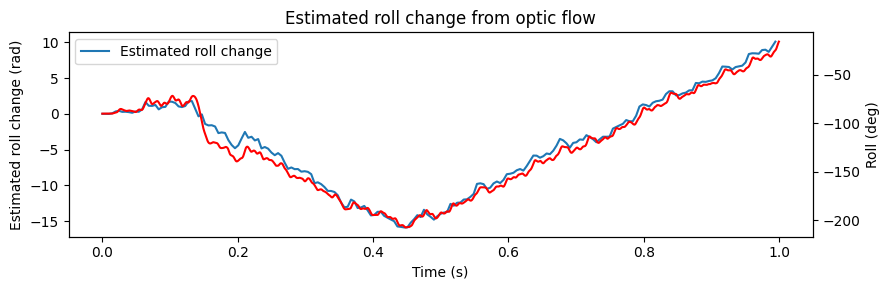

In [23]:
# unwrapping the roll
fly_roll_hist = np.unwrap(fly_roll_hist, discont=np.pi)

time = np.arange(len(fly_roll_hist)) * sim.timestep

fig, ax = plt.subplots(1, 1, figsize=(9, 3), tight_layout=True)
ax.plot(time[::vision_window_length][:-1], cum_estimated_orient_change, label="Estimated roll change")
twin_ax = ax.twinx()
twin_ax.plot(time, np.rad2deg(fly_roll_hist), color="red", label="Roll")
twin_ax.set_ylabel("Roll (deg)")
ax.set_title("Estimated roll change from optic flow")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Estimated roll change (rad)")
ax.legend(loc="upper left")

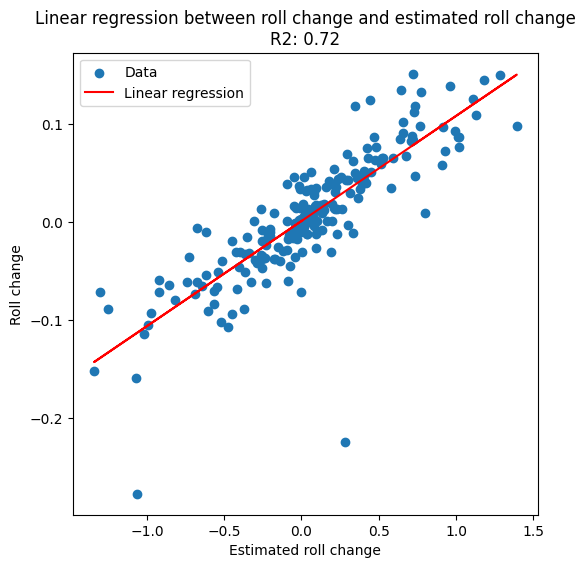

In [24]:
from sklearn.linear_model import LinearRegression

# get linear relationship between roll and optic flow
roll_change = np.diff(fly_roll_hist[::vision_window_length])

####################
#TODO: Fit a linear model between the optic flow vector and the roll change
X = np.array(estimated_orient_change).reshape(-1, 1)
y = roll_change

heading_flow_model = LinearRegression().fit(X, y)
y_pred = heading_flow_model.predict(X)
####################

plt.figure(figsize=(6, 6))
plt.scatter(X, y, label="Data")
plt.plot(X, y_pred, color="red", label="Linear regression")
plt.xlabel("Estimated roll change")
plt.ylabel("Roll change")
plt.legend()
plt.title(f"Linear regression between roll change and estimated roll change\nR2: {heading_flow_model.score(X, y):.2f}")

plt.show()

In [25]:
fly, cam, arena, sim = create_sim(enable_vision=True)

display_handle = display(None, display_id=True)

obs_history = []
info_history = []
actions_history = []
vision_history = []

prev_imgs = None
prev_update_time = 0

flow_heading_change = []
flow_heading_time = []

display_handle = display(None, display_id=True)

running_time = 4 * straight_timesteps + 3 * turn_timesteps
# running around the arena consists of 4 straight runs and 3 turns
for i in tqdm.trange(running_time):
    control = (
        (1, 1) if i % (straight_timesteps + turn_timesteps) <= straight_timesteps else (-0.8, 1.2)
    )
    actions_history.append(control)
    obs, reward, terminated, truncated, info = sim.step(np.array(control))
    obs_history.append(obs)
    info_history.append(info)
    img = sim.render()

    # compute vision based path
    vision_history.append(obs["vision"])
    if sim.curr_time - prev_update_time > vision_time_scale:
        curr_img = prepare_fly_vision(obs["vision"])
        if prev_imgs is not None:
            flow = compute_optic_flow(prev_imgs, curr_img)
            flow_heading_change.append(get_mean_x_flow(flow))
            flow_heading_time.append(sim.curr_time)
        prev_imgs = curr_img
        prev_update_time = sim.curr_time

    # show the image in real time in the jupyter notebook
    if img is not None and len(img) > 0 and img[0] is not None:
        display_handle.update(
            Image(data=cv2.imencode(".jpg", img[0][:, :, ::-1])[1].tobytes())
        )

clear_output()

cam.save_video(output_dir / "baseball_flow.mp4", stabilization_time=0)
Video(output_dir / "baseball_open_loop.mp4")


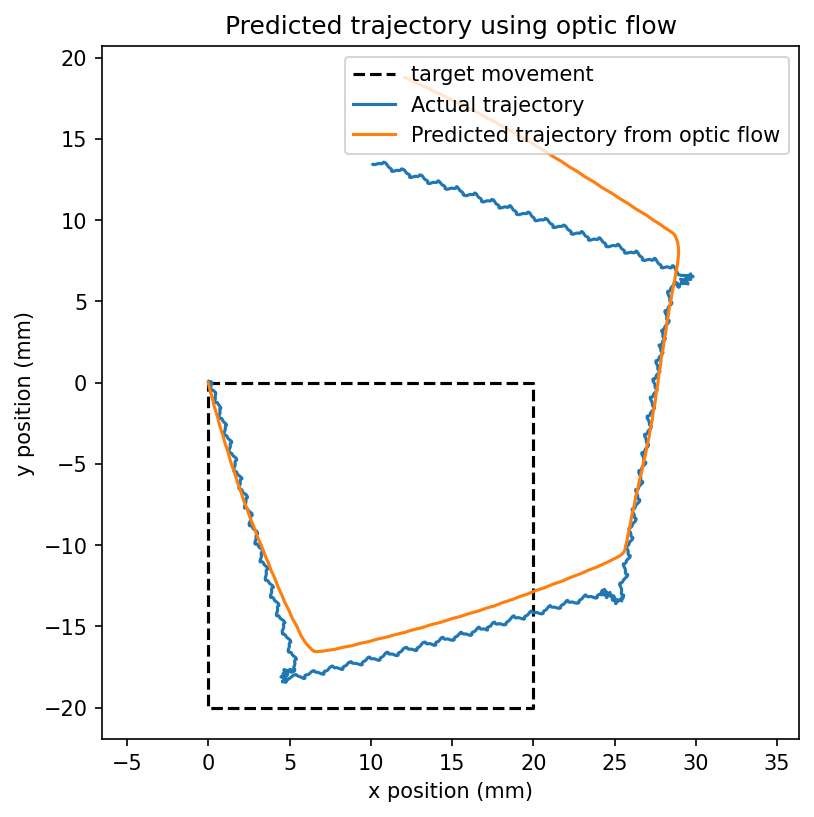

In [26]:
# Accumulate the heading change and predict the fly's heading
flow_heading = np.cumsum(flow_heading_change)
flow_pred_heading = heading_flow_model.predict(np.array(flow_heading).reshape(-1, 1))

fly_pos = np.array([obs["fly"][0] for obs in obs_history])
fly_orientation = np.array([obs["fly_orientation"] for obs in obs_history])
end_effector_pos = np.array([obs["end_effectors"] for obs in obs_history])
contact_forces = np.array([np.linalg.norm(obs["contact_forces"], axis=1) for obs in obs_history])

stride_length = get_stride_length(fly_pos[:, :2], fly_orientation, end_effector_pos[:, :, :2])
stride_length_difference, stride_length_sum = extract_proprioceptive_variables(
    stride_length, contact_forces, time_scale=ts, contact_force_thr=f_thr, dt=timestep
)

window_len = int(ts / sim.timestep)
vision_window_len = int(vision_time_scale / sim.timestep)

# Path int. not performed when not enough data is available. Start from the real
# heading at the moment when path int. actually starts.
hx_start, hy_start = fly_orientation[vision_window_len, :2]
real_heading_start = np.arctan2(hy_start, hx_start)
flow_pred_heading += real_heading_start

displacement_diff_tim = np.arange(ts, running_time*timestep, timestep)
flow_pred_heading_interp = np.interp(displacement_diff_tim, flow_heading_time, flow_pred_heading)

# Integrate displacement
displacement_diff_pred = prop_disp_model(stride_length_sum)

displacement_diff_x_pred = np.cos(flow_pred_heading_interp) * displacement_diff_pred
displacement_diff_y_pred = np.sin(flow_pred_heading_interp) * displacement_diff_pred

pos_x_pred = np.cumsum(displacement_diff_x_pred / window_len)
pos_y_pred = np.cumsum(displacement_diff_y_pred / window_len)
pos_pred_flow = np.concatenate([pos_x_pred[:, None], pos_y_pred[:, None]], axis=1)

# Pad with NaN where prediction not available
heading_pred = np.concatenate([np.full(window_len, np.nan), heading_pred])
pos_pred_flow = np.concatenate([np.full((window_len, 2), np.nan), pos_pred_flow], axis=0)

desired_square_size = 20
plt.figure(figsize=(6,6), dpi=150)
plt.plot(
    [0, desired_square_size, desired_square_size, 0, 0],
    [0, 0, -desired_square_size, -desired_square_size, 0],
	"k--",
	label="target movement"
)
plt.plot([observation["fly"][0][0] for observation in obs_history], [observation["fly"][0][1] for observation in obs_history], label="Actual trajectory")
plt.plot(pos_pred_flow[:, 0], pos_pred_flow[:, 1], label="Predicted trajectory from optic flow")
plt.title("Predicted trajectory using optic flow")
plt.legend(loc = "upper right")
plt.axis('equal')
plt.xlabel("x position (mm)")
plt.ylabel("y position (mm)")
plt.show()

# Polarized light based path integration

Insects like bees and ants are known to use [polarized light](https://en.wikipedia.org/wiki/Polarization_(waves)) to track their heading. While the sun emits unpolarized light, scattering in the atmosphere polarizes the light in the sky. Insects are able to detect the direction of the polarization using specialized photoreceptors in the dorsal rim area. The polarization might vary through the day but will stay fixed at the timescale relevant for path integration. Insects are then able to use the direction as the polarized just like a human would use a compass and thus keep track of their heading and how it changes in absolute coordinates.


*Bees even uses polarized light to communicate food sources location you can learn more about this [here](https://www.science.org/doi/10.1126/science.ade1702) !!!*
 

NeuroMechFly sadly has not detailed implementation of polarized light and it's detection. As we are not interested in the detailed physiological way polarized light is transformed into the absolute heading of the animal we will just give the absolute heading to the fly and see how it helps with path integration. 

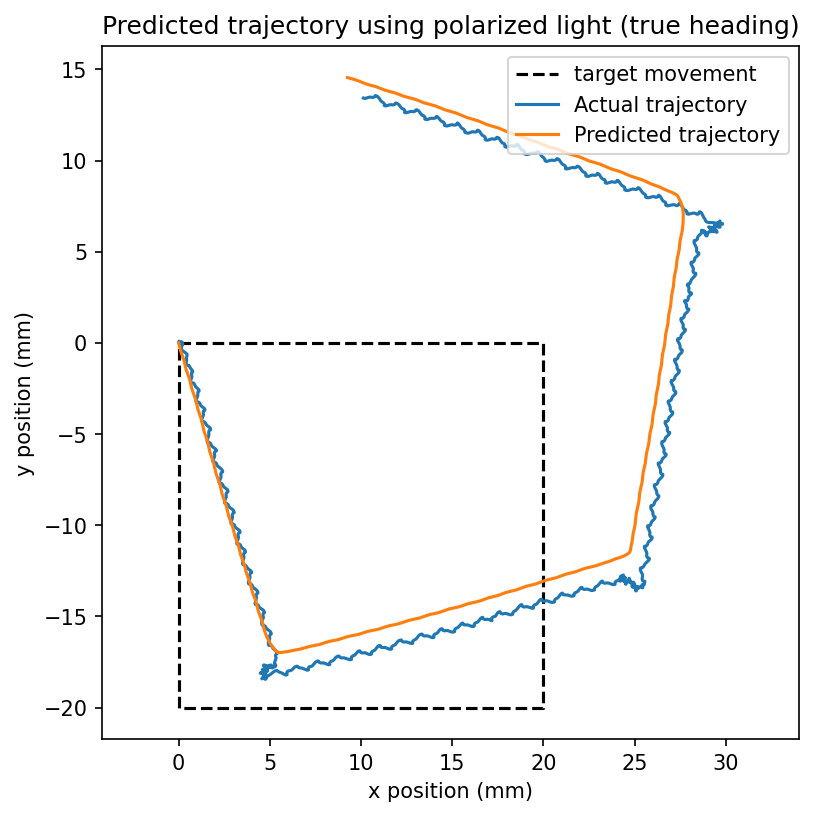

In [27]:
####################
#TODO: extract the true heading of the fly
true_heading = np.arctan2(fly_orientation[:, 1], fly_orientation[:, 0])
####################
# use the GT heading from the magic fly compass
true_heading = true_heading[window_len:]

displacement_diff_x_pred = np.cos(true_heading) * displacement_diff_pred
displacement_diff_y_pred = np.sin(true_heading) * displacement_diff_pred

pos_x_pred = np.cumsum(displacement_diff_x_pred / window_len)
pos_y_pred = np.cumsum(displacement_diff_y_pred / window_len)
pos_pred_true_heading = np.concatenate([pos_x_pred[:, None], pos_y_pred[:, None]], axis=1)

# Pad with NaN where prediction not available
true_heading = np.concatenate([np.full(window_len, np.nan), true_heading])
pos_pred_true_heading = np.concatenate([np.full((window_len, 2), np.nan), pos_pred_true_heading], axis=0)

desired_square_size = 20
plt.figure(figsize=(6,6), dpi=150)
plt.plot(
    [0, desired_square_size, desired_square_size, 0, 0],
    [0, 0, -desired_square_size, -desired_square_size, 0],
	"k--",
	label="target movement"
)
plt.plot([observation["fly"][0][0] for observation in obs_history], [observation["fly"][0][1] for observation in obs_history], label="Actual trajectory")
plt.plot(pos_pred_true_heading[:, 0], pos_pred_true_heading[:, 1], label="Predicted trajectory")
plt.title("Predicted trajectory using polarized light (true heading)")
plt.legend(loc = "upper right")
plt.axis('equal')
plt.xlabel("x position (mm)")
plt.ylabel("y position (mm)")
plt.show()

## Closed loop path integration with polarized light

Now that the fly is able to accurately track its position and heading over time, it can use this estimate of its position to correct errors in its movements and better follow the square trajectory.

Instead of implementing a controller based on the fly, we instead simplify things and rely on a control approach from robotics - specifically from section 4.2.1 in [Corke et al., 2011](https://doi.org/10.1007/978-3-642-20144-8).

Given a current position and heading $(x,y,\theta)$ and a desired goal position $(x^*,y^*)$, the controller outputs a distance error $\delta_v$ and angle to the goal $\theta^*$

$$\begin{aligned}
    \delta_v &= \sqrt{(x^* - x)^2 + (y^* - y)^2} \\
    \theta^* &= \tan^{-1} \left(\frac{y^* - y}{x^* - x}\right)
\end{aligned}$$

These quantities are then used in a proportional controller to output the desired linear and rotational velocity of the fly

$$\begin{aligned}
    v^* &= K_v \delta_v \\
    \omega^* &= K_h (\theta^* \ominus \theta)
\end{aligned}$$

where $\ominus$ is the wrapped angular difference function, which returns a result in the range $[-\pi,\pi]$.

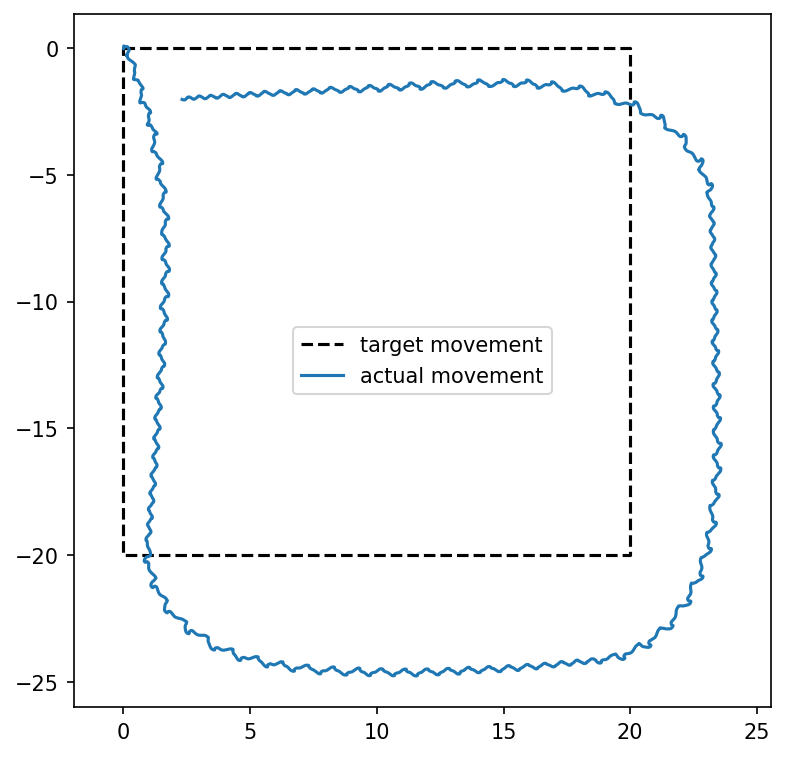

In [28]:
fly, cam, arena, sim = create_sim()

display_handle = display(None, display_id=True)
display_handle2 = display(None, display_id=True)

last_end_effector_pos = None
path_integration_buffer = []
delta_distance_preds = []
delta_heading_preds = []

obs_history = [fly.get_observation(sim)]
xs = []
ys = []
headings = []

contact_force_thr = 1.0
window_len = int(ts / sim.timestep)

# with adhesion
displacement_model = prop_disp_model

init_obs = fly.get_observation(sim)
init_pos_obs = init_obs["fly"]
init_or_obs = init_obs["fly_orientation"]
xs.append(init_pos_obs[0, 0])
ys.append(init_pos_obs[0, 1])
headings.append(np.arctan2(init_or_obs[1], init_or_obs[0]))

current_goal_index = 0
goals = [
    (0, -desired_square_size),
    (desired_square_size, -desired_square_size),
    (desired_square_size, 0),
    (0, 0),
]
while True:
    # CONTROL THE FLY'S SPEED BASED ON PATH INTEGRATION
    # compare the current path integration position estimates to the goal
    current_pos = np.array((xs[-1], ys[-1]))
    current_heading = headings[-1]
    error = goals[current_goal_index] - current_pos

    error_dist = np.linalg.norm(error)
    error_heading = np.arctan2(error[1], error[0]) - current_heading
    # wrap this error to +/- pi
    error_heading = ((error_heading + np.pi) % (2 * np.pi)) - np.pi

    speed_control = np.sqrt(1 / 20 * error_dist)
    speed_heading = 1 * error_heading
    speed_left = speed_control * (1 - speed_heading / 2)
    speed_right = speed_control * (1 + speed_heading / 2)

    if current_goal_index < len(goals) - 1 and error_dist < 4:
        print("Reached goal!")
        current_goal_index += 1
    elif current_goal_index == len(goals) - 1 and error_dist < 2:
        print("Finished")
        break

    control = (speed_left, speed_right)

    obs, reward, terminated, truncated, info = sim.step(np.array(control))
    obs_history.append(obs)
    img = sim.render()

    # # DO THE PATH INTEGRATION
    contact_forces = np.linalg.norm(obs["contact_forces"], axis=1)
    end_effector_relative = absolute_to_relative_pos_heading(
        obs["end_effectors"][:, :2], obs["fly"][0][:2], np.arctan2(obs["fly_orientation"][1], obs["fly_orientation"][0])
    )

    if last_end_effector_pos is None:
        end_effector_diff = np.zeros_like(end_effector_relative)
    else:
        end_effector_diff = end_effector_relative - last_end_effector_pos
    last_end_effector_pos = end_effector_relative

    # buffer of window_len
    current_stride_left = np.sum(
        end_effector_diff[:3, 0] * (contact_forces[:3] > contact_force_thr)
    )
    current_stride_right = np.sum(
        end_effector_diff[3:, 0] * (contact_forces[3:] > contact_force_thr)
    )
    # cumulatively sum the stride lengths on each side in a buffer
    path_integration_buffer.append(
        (
            path_integration_buffer[-1][0] + current_stride_left,
            path_integration_buffer[-1][1] + current_stride_right,
        )
        if len(path_integration_buffer) > 0
        else (current_stride_left, current_stride_right)
    )
    if len(path_integration_buffer) < window_len:
        continue

    stride_left_diff = path_integration_buffer[-1][0] - path_integration_buffer[0][0]
    stride_right_diff = path_integration_buffer[-1][1] - path_integration_buffer[0][1]

    path_integration_buffer.pop(0)

    stride_length_sum = stride_left_diff + stride_right_diff
    stride_length_difference = stride_left_diff - stride_right_diff

    delta_distance_preds.append(stride_length_sum)
    delta_heading_preds.append(stride_length_difference)

    # integrate the estimate of the fly's distance travelled and heading change over time
    xs.append(
        xs[-1]
        + np.cos(headings[-1]) * displacement_model(stride_length_sum) / window_len
    )
    ys.append(
        ys[-1]
        + np.sin(headings[-1]) * displacement_model(stride_length_sum) / window_len
    )
    # here the fly gets its true heading from the polarised light
    headings.append(np.arctan2(obs["fly_orientation"][1], obs["fly_orientation"][0]))

    # show the image and path integration plots in real time in the jupyter notebook
    if img is not None and len(img) > 0 and img[0] is not None:
        display_handle.update(
            Image(data=cv2.imencode(".jpg", img[0][:, :, ::-1])[1].tobytes())
        )

        fig = plt.figure(figsize=(4,4))
        plt.plot(
            [0, desired_square_size, desired_square_size, 0, 0],
            [0, 0, -desired_square_size, -desired_square_size, 0],
            "k--",
            label="target movement",
        )
        plt.plot(
            [observation["fly"][0][0] for observation in obs_history],
            [observation["fly"][0][1] for observation in obs_history],
            label="actual movement",
        )
        plt.plot(xs, ys, label="path integration")
        plt.legend()
        plt.axis("equal")
        width, height = fig.canvas.get_width_height()
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8).reshape(
            height, width, -1
        )
        plt.close(fig)
        display_handle2.update(
            Image(data=cv2.imencode(".jpg", img[:, :, 1:])[1].tobytes())
        )

clear_output()

cam.save_video(output_dir / "closed-loop-control.mp4", stabilization_time=0)

plt.figure(figsize=(6, 6), dpi=150)
plt.plot(
    [0, desired_square_size, desired_square_size, 0, 0],
    [0, 0, -desired_square_size, -desired_square_size, 0],
    "k--",
    label="target movement",
)
plt.plot(
    [observation["fly"][0][0] for observation in obs_history],
    [observation["fly"][0][1] for observation in obs_history],
    label="actual movement",
)
plt.legend()
plt.axis("equal")
plt.show()

Video(output_dir / "closed-loop-control.mp4")

Our fly is not yet a pro at baseball but implementing path integration already made it much better !

Based on the final trajectory and today's lecture how could we further improve the baseball capabilities of our fly ?

**Answer:**

**Polarized light provides an optimal heading estimate, limited only by sensor noise. As observed in the baseball trajectory, the primary source of error arises from the distance estimation, which systematically underestimates the actual traveled distance. Bees are known to utilize translational optic flow to monitor their traveling speed. Incorporating this mechanism into our model could enhance the accuracy of path integration. Another possible improvement involves fusing multiple sensory modalities or introducing nonlinearities into the stride length–distance regression. Lastly, one could envision an agent that, based on visual input, develops a more global understanding of its environment—similar to how mammals use place cells—potentially leading to a more reliable representation of traveled distance.**